Vamos a crear unos datos MUYYY sencillitos, y vamos a entrenar el modelo en RECONSTRUIRLOS solo. No vamos a pretender que haga nada más.   
Luego le meteremos lo de al AssDis.

In [25]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer

from torch import optim

from torch.utils.data import DataLoader,Dataset

# Los datos sinteticos

Voy a hacer un generador que nos de una secuencia regular, con puntos de anomalia


In [26]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


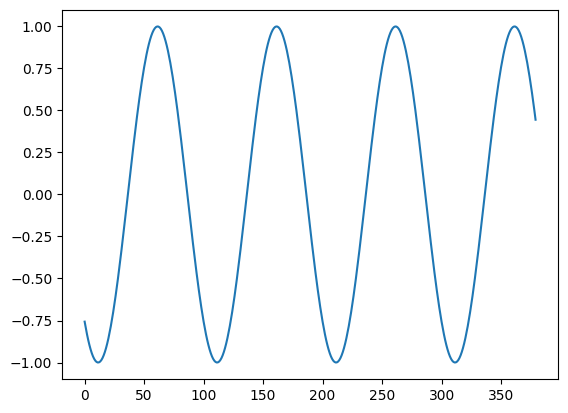

In [27]:
y=sinne(380,sf=0.1,f=1,phase=4)
plt.plot(y)

Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [28]:
class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y, y.flip(0)


In [29]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [30]:
a,b=next(iter(dataloader))

In [31]:
a.shape

torch.Size([32, 600, 1])

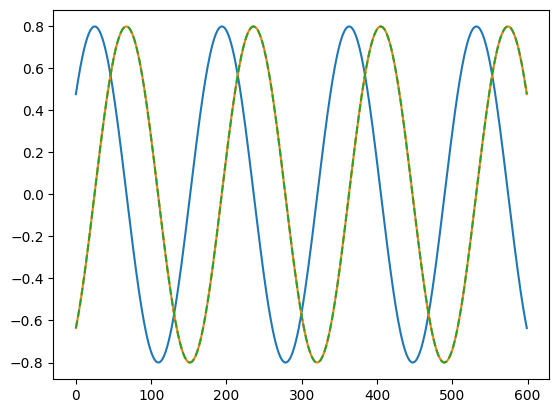

In [32]:
plt.plot(a[1])
plt.plot(a.flip(1)[1])
plt.plot(b[1],"--")

No es todo lo personalizable que querria, pero bien, ahora creamos la red. 

In [33]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=4, e_layers=1, d_ff=32,
                          dropout=0.4, activation='gelu', output_attention=True)

In [34]:
def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




def count_parameters(model):
    
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
count_parameters(modelo)

Total trainable parameters: 6853


6853

In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.cuda()
modelo.train()

# Entrenamiento
num_epochs = 60
for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        labels=labels.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        loss = criterion(outputs, labels)

        # Backward y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,15 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

print("Entrenamiento finalizado")

Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [1/125], Loss: 1.6742
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [2/125], Loss: 1.3609
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [3/125], Loss: 1.8953
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [4/125], Loss: 1.9769
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [5/125], Loss: 1.9735
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [6/125], Loss: 2.4365
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [7/125], Loss: 1.6243
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [8/125], Loss: 2.1733
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [9/125], Loss: 1.7370
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [10/125], Loss: 1.8141
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [11/125], Loss: 1.7929
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [12/125], Loss: 1.8113
Warmup: Updating learning rate to 0.0
Epoch [1/60

In [42]:
a=next(iter(dataloader))
a1=a[0].float().to("cuda:0")
modelo.eval()
y=modelo(a1)


In [43]:
torch.cuda.empty_cache()

In [44]:
z=y[0].squeeze().cpu().detach().numpy()
z1=y[1][0].squeeze().cpu().detach().numpy()
z2=y[2][0].squeeze().cpu().detach().numpy()
b=a[1].squeeze().cpu().detach().numpy()

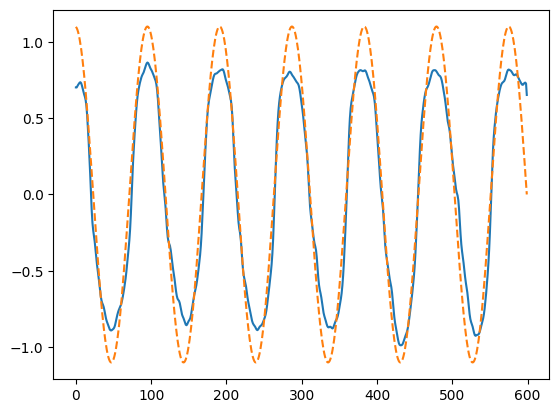

In [45]:
plt.plot(z[18])
plt.plot(b[18],"--")

In [40]:
z1.shape

(32, 4, 600, 600)

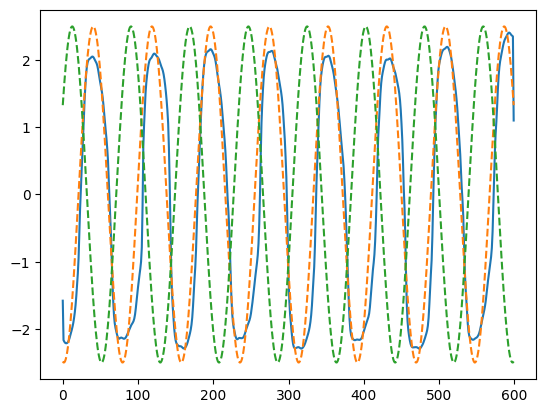

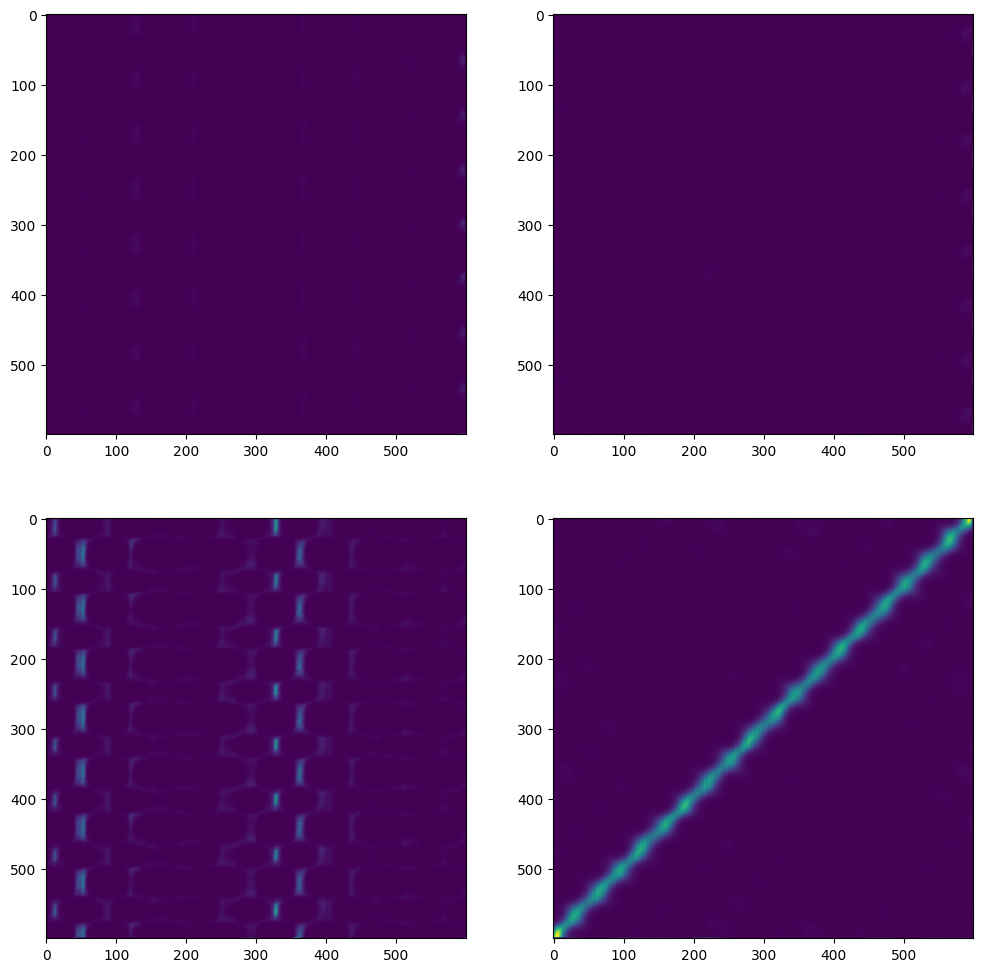

In [52]:
n=2

plt.plot(z[n])
plt.plot(b[n],"--")
plt.plot(a[0][n],"--")

plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(z1[n][i])